In [1]:
%matplotlib inline
import os
import shutil
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(100)
tf.random.set_random_seed(100)

# Tensorboard의 Log파일이 저장될 위치
LOG_DIR = "./logs/"
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR,exist_ok=True)

### Tensorboard를 Colab에서 띄우기

colab은 로컬 컴퓨터에서 돌아가는 것이 아니라, 구글이 제공하는 컴퓨터 환경에서 돌아간다. 그렇기 때문에, 우리는 Tensorboard에 접근하기 위해서는, 로컬 컴퓨터처럼 바로 

localhost:6006 식으로 접근할 수 없고, 우회하는 방법을 택해야 한다. 이 때 이용하는 것이 ngrok으로, 6006 포트에서 받는 Tensorboard에 대한 신호를 ngrok.com에서 제공하는 사이트로, 우회해서 통신할 수 있도록 도와준다. (이는 중요한 것이 아니므로, 가볍게 알고만 지나가면 된다, 다만 colab와 같은 개발 환경을 이용할 때에는 매우 요긴하게 쓸 수 있다.)

In [ ]:
# ngrok을 다운 받고 압축 풂
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# tensorboard 실행
get_ipython().system_raw(
'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

# ngrok 실행(6006포트를 listening)
get_ipython().system_raw('./ngrok http 6006 &')

# ngrok이 개통된 public url가져오기
!curl -s http://localhost:4040/api/tunnels | python3 -c \
"import sys, json;print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

## 임의의 데이터셋 만들기

    우리는 아래와 같이, R&D 투자 비율에 따라, 내년 매출 성장률에 관련된 데이터셋이 있다고 하자.

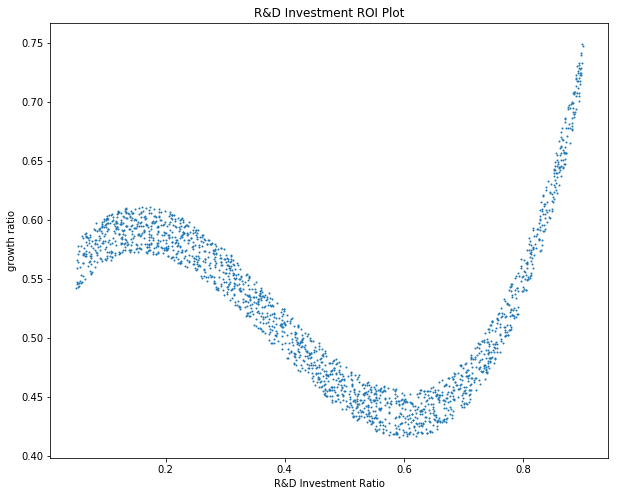

In [2]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

invests = np.random.uniform(0.05,0.9, 2000) # 20% ~ 80% 까지 기술 투자 비율
growths = np.array([random_polynomial(x)+np.random.uniform(0,0.04) 
           for x in invests]) # 예상 수익률

plt.figure(figsize=(10,8))
plt.scatter(invests, growths, s=1)
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.show()

invests = invests.reshape(-1,1) # (data_nums, feature_nums) => (1000, 1)
growths = growths.reshape(-1,1) # (data_nums, target_nums) => (1000, 1)

## 학습 데이터 셋과 훈련 데이터 셋을 나누기

머신러닝에서는 데이터를 보통 훈련 데이터셋(Train Dataset)과 시험 데이터셋(Test Dataset)으로 나눠 학습과 실험을 수행하는 것이 일반적

1. 훈련 데이터을 사용하여 학습하면서 최적의 매개변수를 찾음
2. 시험 데이터를 사용하여 앞서 훈련한 모델의 성능을 평가

왜 나눠야 할까? 

우리가 범용적으로 사용할 수 있는 모델을 원하기 때문. 이 범용 능력을 제대로 평가하기 위해 훈련 데이터와 시험 데이터를 분리. 
범용 능력은 아직 보지 못한 데이터로도 문제를 올바르게 풀어내는 능력. 이 범용 능력을 획득하는 것이 머신러닝의 최종 목표. 

데이터셋 하나로만 매개변수의 학습과 평가를 수행하면 올바른 평가가 이루어질 수 없다.

In [3]:
# index를 생성하여, 순서를 섞음
idx = np.arange(len(invests))
np.random.shuffle(idx) 

# 학습 데이터셋 : 평가 데이터셋 = 7:3
train_nums = int(len(invests) * 0.7)

train_idx, test_idx = idx[:train_nums], idx[train_nums:]

without_train = set(np.arange(len(invests))) - set(train_idx)
test_idx = np.array(list(without_train))

In [4]:
# index를 생성하여, 순서를 섞음
idx = np.arange(len(invests))
np.random.shuffle(idx) 

# 학습 데이터셋 : 평가 데이터셋 = 7:3
train_nums = int(len(invests) * 0.7)
train_idx, test_idx = idx[:train_nums], idx[train_nums:]

# 데이터 셋 분리
train_invests, train_growths = invests[train_idx], growths[train_idx]
test_invests, test_growths = invests[test_idx], growths[test_idx]

## 학습시킬 Graph 만들기

In [5]:
num_unit_1 = 200 # 1번째 은닉층 unit 수
num_unit_2 = 200 # 2번째 은닉층 unit 수

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')

    # 은닉층 1
    with tf.variable_scope('hidden_1'):
        W1_init = tf.truncated_normal((1,num_unit_1))
        W1 = tf.Variable(W1_init,name='kernel')
        b1_init = tf.constant(0.,shape=[num_unit_1],dtype=tf.float32)
        b1 = tf.Variable(b1_init,name='bias')

        z1 = tf.matmul(X,W1) + b1
        a1 = tf.nn.sigmoid(z1)

    # 은닉층 2
    with tf.variable_scope('hidden_2'):
        W2_init = tf.truncated_normal((num_unit_1,num_unit_2))
        W2 = tf.Variable(W2_init,name='kernel')
        b2_init = tf.constant(0.,shape=[num_unit_2], dtype=tf.float32)
        b2 = tf.Variable(b2_init,name='bias')

        z2 = tf.matmul(a1,W2) + b2
        a2 = tf.nn.sigmoid(z2)

    # 출력층
    with tf.variable_scope('output'):
        W3_init = tf.truncated_normal((num_unit_2,1))
        W3 = tf.Variable(W3_init,name='kernel')
        b3_init = tf.constant(0.,shape=[1], dtype=tf.float32)
        b3 = tf.Variable(b3_init,name='bias')

        y_pred = tf.add(tf.matmul(a2,W3),b3,name='prediction')            

    # 손실 함수
    with tf.variable_scope('loss'):
        error = y - y_pred
        loss = tf.reduce_mean(tf.square(error), name='mse')

    # 성능지표
    with tf.variable_scope('metric'):
        rmse = tf.sqrt(loss, name='rmse')

    # Summary (Tensorboard에 기록하기 위함)
    tf.summary.histogram("hidden-1-Weight", W1)
    tf.summary.histogram("hidden-2-Weight", W2)
    tf.summary.histogram("output-Weight", W3)
    tf.summary.scalar("rmse", rmse)
    
    # Training operation
    # 텐서플로우에서 지원하는 자동 미분(내부에서 오차역전파법을 이용하였음)
    grad_W1, grad_W2, grad_W3 = tf.gradients([loss],[W1,W2,W3])
    grad_b1, grad_b2, grad_b3 = tf.gradients([loss],[b1,b2,b3])
    
    learning_rate = 0.01
    update_W1 = tf.assign(W1, W1 - grad_W1 * learning_rate)
    update_W2 = tf.assign(W2, W2 - grad_W2 * learning_rate)
    update_W3 = tf.assign(W3, W3 - grad_W3 * learning_rate)
    
    update_b1 = tf.assign(b1, b1 - grad_b1 * learning_rate)
    update_b2 = tf.assign(b2, b2 - grad_b2 * learning_rate)
    update_b3 = tf.assign(b3, b3 - grad_b3 * learning_rate)    
    
    train_op = tf.group([update_W1,update_W2,update_W3,
                          update_b1,update_b2,update_b3])


    0th epoch RMSE : 10.929
  100th epoch RMSE : 0.045
  200th epoch RMSE : 0.045
  300th epoch RMSE : 0.045
  400th epoch RMSE : 0.045
  500th epoch RMSE : 0.045
  600th epoch RMSE : 0.045
  700th epoch RMSE : 0.045
  800th epoch RMSE : 0.045
  900th epoch RMSE : 0.044
 1000th epoch RMSE : 0.044
 1100th epoch RMSE : 0.044
 1200th epoch RMSE : 0.044
 1300th epoch RMSE : 0.044
 1400th epoch RMSE : 0.044
 1500th epoch RMSE : 0.044
 1600th epoch RMSE : 0.044
 1700th epoch RMSE : 0.043
 1800th epoch RMSE : 0.043
 1900th epoch RMSE : 0.043
 2000th epoch RMSE : 0.043
 2100th epoch RMSE : 0.043
 2200th epoch RMSE : 0.043
 2300th epoch RMSE : 0.043
 2400th epoch RMSE : 0.043
 2500th epoch RMSE : 0.042
 2600th epoch RMSE : 0.042
 2700th epoch RMSE : 0.042
 2800th epoch RMSE : 0.042
 2900th epoch RMSE : 0.042
 3000th epoch RMSE : 0.042
 3100th epoch RMSE : 0.042
 3200th epoch RMSE : 0.042
 3300th epoch RMSE : 0.041
 3400th epoch RMSE : 0.041
 3500th epoch RMSE : 0.041
 3600th epoch RMSE : 0.041


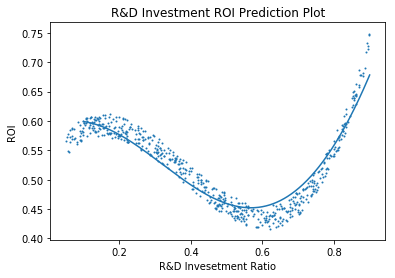

In [6]:
# 학습
n_epoch = 20000
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"simple_regression/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"simple_regression/test/")
    
    for epoch in range(n_epoch):
        # 학습
        sess.run(train_op,feed_dict={X:train_invests,
                                     y:train_growths})
        
        if epoch % 100 == 0:
            # 1000 Epoch 마다 저장 Tensorboard에 Summary Value 저장
            ## Train 
            summary_str = sess.run(summary_op, feed_dict={
                X: train_invests, y:train_growths
            })
            train_writer.add_summary(summary_str, global_step=epoch)
            ## Test
            summary_str,rmse_value = sess.run([summary_op,rmse], 
                          feed_dict={X: test_invests, y:test_growths})
            test_writer.add_summary(summary_str, global_step=epoch)            

            print("{:5d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))        
    
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})
    
plt.scatter(test_invests, test_growths, s=1)
plt.plot(test_xs,pred_ys)
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()


## 텐서플로우 코드를 High-API로 간소화

In [ ]:
num_unit_1 = 200 # 1번째 은닉층 unit 수
num_unit_2 = 200 # 2번째 은닉층 unit 수

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    
    # Weight 초기화 함수
    weight_initializer = tf.initializers.truncated_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.dense(X, num_unit_1, activation=tf.nn.sigmoid,
                               kernel_initializer=weight_initializer, name="hidden_1")
    hidden_2 = tf.layers.dense(hidden_1, num_unit_2, activation=tf.nn.sigmoid, 
                               kernel_initializer=weight_initializer, name='hidden_2')
    y_pred = tf.layers.dense(hidden_2, 1,
                            kernel_initializer=weight_initializer, name='output')
    
    # 손실 함수
    loss = tf.losses.mean_squared_error(y, y_pred)
    
    # 성능 지표
    with tf.variable_scope('metric'):
        rmse = tf.sqrt(loss, name='rmse')

    # Summary
    tf.summary.histogram("hidden-1-Weight", 
                         graph.get_tensor_by_name('hidden_1/kernel:0'))
    tf.summary.histogram("hidden-2-Weight", 
                         graph.get_tensor_by_name('hidden_2/kernel:0'))
    tf.summary.histogram("output-Weight", 
                         graph.get_tensor_by_name('output/kernel:0'))
    tf.summary.scalar("rmse", rmse)
    
    # training operation
    train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

In [ ]:
# 학습
n_epoch = 20000
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"simple_regression/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"simple_regression/test/")
    
    for epoch in range(n_epoch):
        # 학습
        sess.run(train_op,feed_dict={X:train_invests,
                                     y:train_growths})
        
        if epoch % 100 == 0:
            # 1000 Epoch 마다 저장 Tensorboard에 Summary Value 저장
            ## Train 
            summary_str = sess.run(summary_op, feed_dict={
                X: train_invests, y:train_growths
            })
            train_writer.add_summary(summary_str, global_step=epoch)
            ## Test
            summary_str,rmse_value = sess.run([summary_op,rmse], 
                          feed_dict={X: test_invests, y:test_growths})
            test_writer.add_summary(summary_str, global_step=epoch)            

            print("{:5d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))        
    
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})
    
plt.scatter(test_invests, test_growths, s=1)
plt.plot(test_xs,pred_ys)
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()